## Legacy croissant.jax notebook

This notebook uses the original (croissant==4.0.0) interface to croissant.jax Everything works just fine still, but the croissant.jax interface is depracted. Now the same functions are available through croissant directly, which also includes Beam, Sky, and Simulator objects. See example_sim.ipynb for the newer code.

In [1]:
from functools import partial

import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import lunarsky
import matplotlib.pyplot as plt
import s2fft
from healpy import get_nside, projview

import croissant as cro
import croissant.jax as crojax

The croissant.jax interface is deprecated and will be removed in a future release. Please use the croissant interface directly instead.


In [2]:
# simulation parameters
world = "moon"
freq = jnp.arange(1, 51)  # 1-50 MHz
time = lunarsky.Time(
    "2025-12-01 09:00:00"
)  # time at the beginning of the simulation
loc = lunarsky.MoonLocation(lon=0, lat=-22.5)  # location of telescope
topo = lunarsky.LunarTopo(
    obstime=time, location=loc
)  # coordinate frame of telescope
# 240 bins in a sidereal day on the moon
ntimes = 240
dt = cro.constants.sidereal_day[world] / ntimes

## Beam

Simple analytic model of a beam, like a short dipole aligned with x-axis and some smooth frequency dependence.

In [3]:
beam_L = 90
theta = s2fft.sampling.s2_samples.thetas(L=beam_L, sampling="dh")
phi = s2fft.sampling.s2_samples.phis_equiang(L=beam_L, sampling="dh")
phi, theta = jnp.meshgrid(phi, theta)
ct = jnp.cos(theta)
cp = jnp.cos(phi)
sp = jnp.sin(phi)
beam = ct**2 * cp**2 + sp**2
beam = (freq[:, None, None] / freq[-1]) ** (-2) * beam[None]

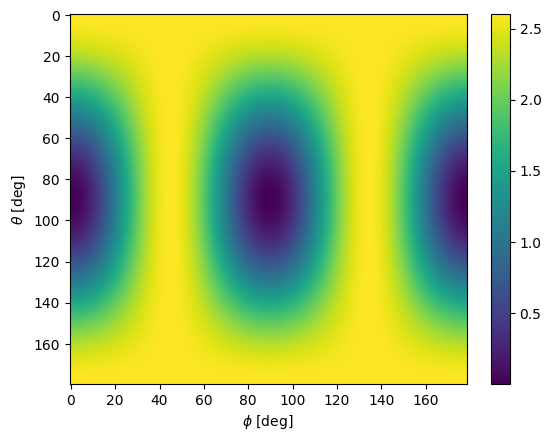

In [4]:
plt.figure()
plt.imshow(beam[30], aspect="auto")
plt.xlabel("$\\phi$ [deg]")
plt.ylabel("$\\theta$ [deg]")
plt.colorbar()
plt.show()

In [5]:
# define the map2alm transform for the beam
beam2alm = partial(
    s2fft.forward_jax,
    L=beam_L,
    spin=0,
    nside=None,
    sampling="dh",
    reality=True,
)
# use vmap t vectorize frequency axis
beam_alm = jax.vmap(beam2alm)(beam)

# normalization for visibilities
norm = crojax.alm.total_power(beam_alm, beam_L - 1)  # lmax = L - 1

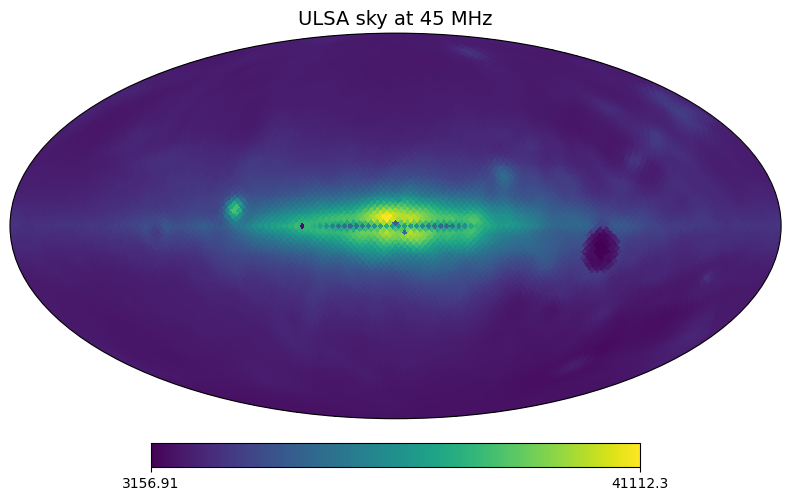

In [6]:
# sky
sky_map = jnp.load("ulsa.npy")
ix = -6
projview(m=sky_map[ix], title=f"ULSA sky at {freq[ix]} MHz")
plt.show()

In [7]:
# define the map2alm transform for the sky
nside = get_nside(sky_map[0])
sky_L = 2 * nside
sky2alm = partial(
    s2fft.forward,
    L=sky_L,
    spin=0,
    nside=nside,
    sampling="healpix",
    method="jax_healpy",
    reality=True,
)

# no vmap support for jax_healpy
sky_alm = jnp.array([sky2alm(m) for m in sky_map])

In [8]:
print(f"{beam_L=}, {sky_L=}")

beam_L=90, sky_L=64


In [9]:
# common L would be the lowest, so we restrict the beam limit
sim_L = sky_L
sim_lmax = sim_L - 1

beam_alm = crojax.alm.reduce_lmax(beam_alm, sim_lmax)

# rotation phases
phases = crojax.simulator.rot_alm_z(sim_lmax, ntimes, dt, world=world)

# get the euler angles and wigner d functions for the coordinate transforms
eul_topo, dl_topo = crojax.rotations.generate_euler_dl(
    sim_lmax, topo, "mcmf"
)  # beam transform, from topocentric to mcmf
eul_gal, dl_gal = crojax.rotations.generate_euler_dl(
    sim_lmax, "galactic", "mcmf"
)  # sky transform, from galactic to mcmf

topo2mcmf = partial(
    s2fft.utils.rotation.rotate_flms,
    L=sim_L,
    rotation=eul_topo,
    dl_array=dl_topo,
)
gal2mcmf = partial(
    s2fft.utils.rotation.rotate_flms,
    L=sim_L,
    rotation=eul_gal,
    dl_array=dl_gal,
)

In [10]:
# coordinate transform
beam_alm_mcmf = jax.vmap(topo2mcmf)(beam_alm)
sky_alm_mcmf = jax.vmap(gal2mcmf)(sky_alm)

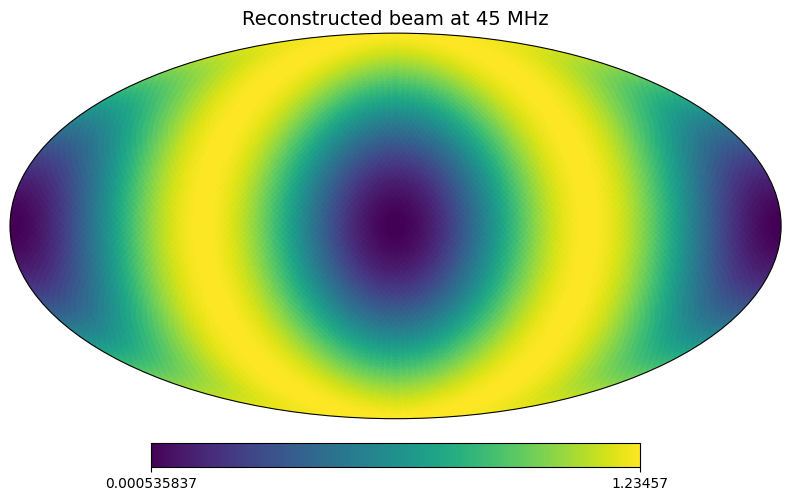

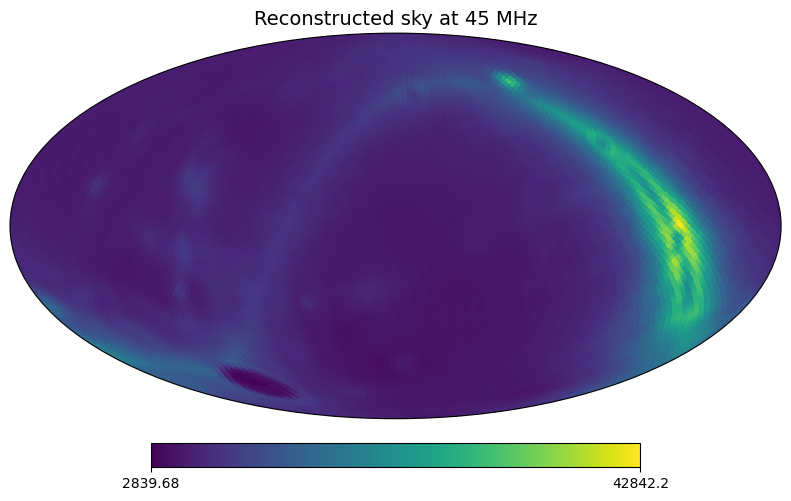

In [11]:
# beam and sky as seen by simulator after transformed back to healpix
beam_reconstructed = s2fft.inverse_jax(
    beam_alm[ix],
    L=sim_L,
    spin=0,
    nside=nside,
    sampling="healpix",
    reality=True,
).real
sky_reconstructed = s2fft.inverse(
    sky_alm_mcmf[ix],
    L=sim_L,
    spin=0,
    nside=nside,
    sampling="healpix",
    method="jax_healpy",
    reality=True,
).real

projview(m=beam_reconstructed, title=f"Reconstructed beam at {freq[ix]} MHz")
projview(m=sky_reconstructed, title=f"Reconstructed sky at {freq[ix]} MHz")
plt.show()

In [12]:
vis = crojax.simulator.convolve(beam_alm, sky_alm, phases).real / norm

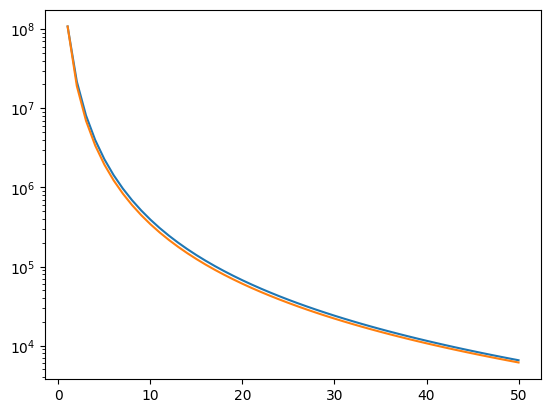

In [13]:
plt.figure()
plt.plot(freq, jnp.mean(sky_map, axis=-1))
plt.plot(freq, jnp.mean(sky_map, axis=-1)[0] * (freq / freq.min()) ** (-2.5))
plt.yscale("log")
plt.show()

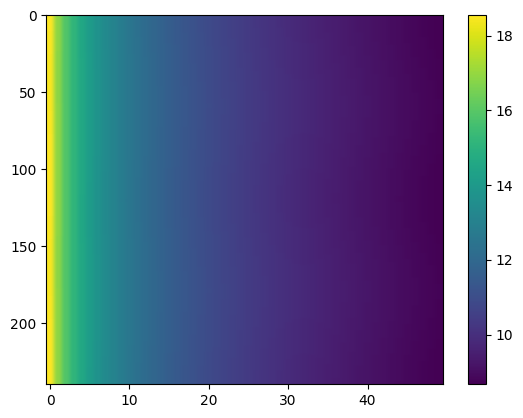

In [14]:
plt.figure()
plt.imshow(jnp.log(vis), aspect="auto")
plt.colorbar()
plt.show()

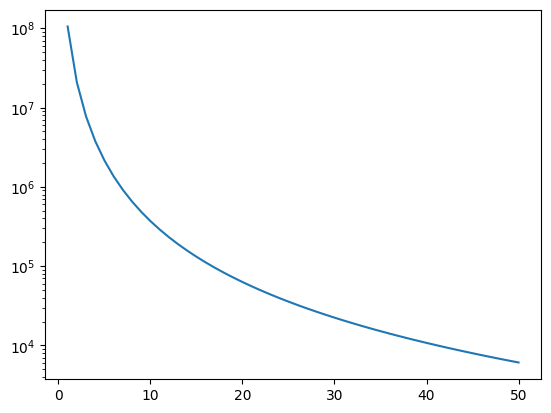

In [15]:
plt.figure()
plt.plot(freq, vis[150])
plt.yscale("log")
plt.show()